Read in the dataset and only keep the dataset we need

In [3]:
!git clone https://github.com/zliucr/CrossNER.git
!mv CrossNER/ner_data/politics ner-dataset
!rm -rf CrossNER

fatal: destination path 'CrossNER' already exists and is not an empty directory.


In [ ]:
import os
import glob
import re
from collections import Counter, defaultdict

ner_dataset = 'ner-dataset'

# Get a list of all files in the ner_dataset directory that end with .txt
file_paths = glob.glob(os.path.join(ner_dataset, '*.txt'))

# Define a regular expression to match entity labels in IOB format
entity_regex = re.compile(r'B-(\w+)')

# Create a dictionary to store the count of each entity in each file
entity_counts = {}

# Loop over each file
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as f:
        # Use Counter to count the number of occurrences of each entity label in the file
        file_counts = Counter(entity_regex.findall(f.read()))
        # Store the counts for the file in the entity_counts dictionary
        entity_counts[file_path] = file_counts

View the labels in the dataset and the cardinality of each label

In [ ]:
import matplotlib.pyplot as plt

entity_cardinality = defaultdict(int)
for file_counts in entity_counts.values():
    for label, count in file_counts.items():
        entity_cardinality[label] += count

for k, v in entity_cardinality.items():
    print(f'{k}: {v}')

Count the number of documents in each file

In [ ]:
file_lengths = defaultdict(int)
total_docs = 0

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        num_docs = text.count('\n\n')
        file_lengths[file_path] = num_docs
        total_docs += num_docs

for file_name, num_docs in file_lengths.items():
    percentage = (num_docs / total_docs) * 100
    print(f'{file_name}: {num_docs} documents, {round(percentage, 1)}%')

View the distribution of the cardinality of each label

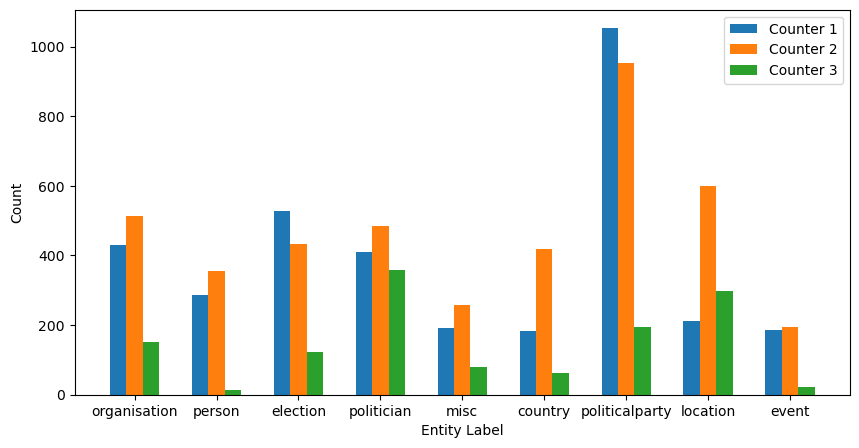

In [131]:
labels = set().union(*entity_counts.values())
x = range(len(labels))

fig, ax = plt.subplots(figsize=(10, 5))

for i, counter in enumerate(entity_counts.values()):
    values = [counter[label] for label in labels]
    ax.bar([pos + i*0.2 for pos in x], values, width=0.2, label=f'Counter {i+1}')

ax.set_xticks([pos + 0.2*(len(entity_counts.values()) - 1)/2 for pos in x])
ax.set_xticklabels(labels)

plt.xlabel('Entity Label')
plt.ylabel('Count')
plt.legend()

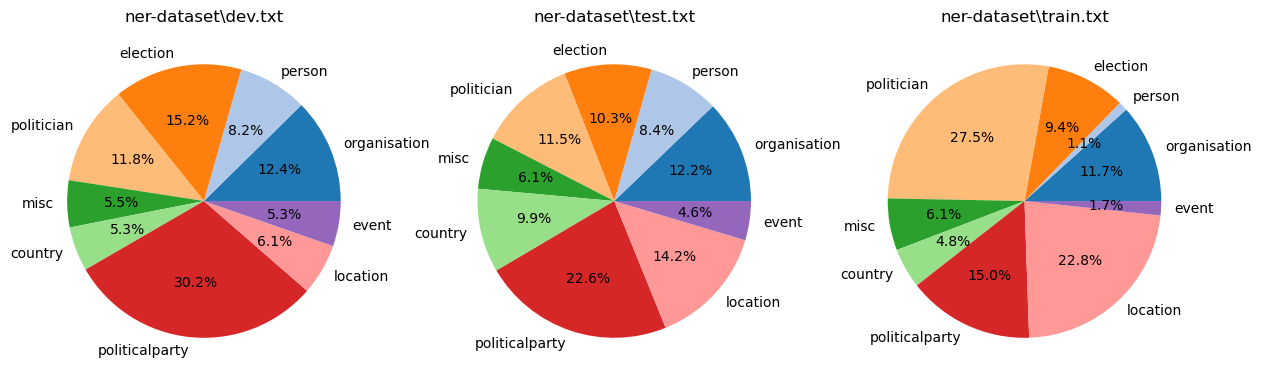

In [132]:
# Get list of entity labels
labels = set()
for values in entity_counts.values():
    labels |= set(values.keys())

# Generate list of colors using the colormap
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(len(labels))]

# Plot pie charts
fig, axs = plt.subplots(1, len(entity_counts), figsize=(15,5))
for i, (filename, values) in enumerate(entity_counts.items()):
    ax = axs[i]
    ax.set_title(filename)
    sizes = [values.get(label, 0) for label in labels]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.show()

In [14]:
# Function to convert text in IOB format to Spacy format
def convert_iob_to_spacy(iob):
    text = ""
    entities = []
    char_count = 0
    split_text = iob.strip().split("\n")

    # Loop through each word in the text
    for row in split_text:
        word, tag = row.split()

        # If the tag is not 'O', process the entities
        if tag != "O":
            if tag[0] == "B":
                entities.append((char_count, char_count + len(word), tag[2:]))
            else:
                entities[-1] = (entities[-1][0], char_count + len(word), entities[-1][2])

        # Add the word to the text and update the character count
        text += word + " "
        char_count += len(word) + 1

    # Return the text and entities
    return text.strip(), entities

In [21]:
# Function to process a corpus file in IOB format and convert it to Spacy format
def process_corpus_file(input_filename, output_filename):
    # Open the input and output files
    with open(input_filename, "r", encoding="utf8") as f:
        with open(output_filename, "a", encoding="utf8") as f2:
            text = ""
            # Read the file line by line
            for line in f:
                # If the line is not empty, add it to the text
                if line.strip() != "":
                    text += line
                # If the line is empty, convert the text to Spacy format and write it to the output file
                else:
                    text, entities = convert_iob_to_spacy(text)
                    f2.write(f'("{text}", {entities}),\n')
                    text = ""

In [ ]:
output_file = "dataset_spacy.txt"
open(output_file, "w", encoding="utf8").close()

# Process each input file and write the converted data to the output file
for input_file in ["train.txt", "dev.txt", "test.txt"]:
    process_corpus_file(input_file, output_file)

Next we need to split the dataset into train, validation and test sets

In [45]:
from sklearn.model_selection import train_test_split
import ast

# Load data from file into a list
with open("data_spacy.txt", "r", encoding="utf-8") as f:
    data = []
    for line in f:
        tup = ast.literal_eval(line.strip())
        data.append(tup[0])

# Split data into train (80%), validation (10%), and test (10%) sets
train_data, temp_data = train_test_split(data, test_size=0.2)
dev_data, test_data = train_test_split(temp_data, test_size=0.5)

# Write the train, dev, and test data to their respective files
def write_data_to_file(file_name, data):
    with open(file_name, "w", encoding="utf-8") as f:
        for tup in data:
            f.write('("' + tup[0] + '", ' + str(tup[1]) + "),\n")

write_data_to_file("train.txt", train_data)
write_data_to_file("dev.txt", dev_data)
write_data_to_file("test.txt", test_data)